# Imports

In [25]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, Pool

# Intro

In this notebook aims to build a model that can predict whether a cellphone customer will cancel their subscription

# Data Loading & Prep

In [26]:
df = pd.read_csv('https://raw.githubusercontent.com/mkleinbort/resource-datasets/master/cell_phone_churn/cell_phone_churn.csv')

df_hold_out_set = df.iloc[::10, :]
df_hold_out_set.to_pickle('data/df_holdout.p')

df = df.drop(index=df_hold_out_set.index)

In [27]:
df.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
1,OH,107,415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False
5,AL,118,510,yes,no,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,False


<AxesSubplot:ylabel='churn'>

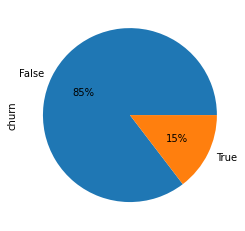

In [29]:
df['churn'].value_counts(normalize=True).plot(kind='pie', autopct=lambda x: f'{x:.0f}%')

# Model Development & Testing

In [31]:
from sklearn.model_selection import train_test_split

def get_Xy(df:pd.DataFrame) -> tuple:
    '''Returns (X, y, X_train, X_test, y_train, y_test, categorical_features)'''
    
    X = df.drop(columns=['churn'])
    y = df['churn'].astype(str)

    categorical_features = [i for i, dtype in enumerate(X.dtypes) if dtype == 'object']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    return X, y, X_train, X_test, y_train, y_test, categorical_features

X, y, X_train, X_test, y_train, y_test, categorical_features = get_Xy(df)

In [32]:
y_test.value_counts(normalize=True)

False    0.863333
True     0.136667
Name: churn, dtype: float64

In [33]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(metric_period=100)

model.fit(X_train, y_train, cat_features=categorical_features)

Learning rate set to 0.014969
0:	learn: 0.6755606	total: 7.79ms	remaining: 7.78s
100:	learn: 0.2120079	total: 388ms	remaining: 3.45s
200:	learn: 0.1534261	total: 686ms	remaining: 2.73s
300:	learn: 0.1319514	total: 944ms	remaining: 2.19s
400:	learn: 0.1193855	total: 1.23s	remaining: 1.83s
500:	learn: 0.1100123	total: 1.48s	remaining: 1.48s
600:	learn: 0.1017202	total: 1.76s	remaining: 1.17s
700:	learn: 0.0944769	total: 2.03s	remaining: 866ms
800:	learn: 0.0866779	total: 2.3s	remaining: 571ms
900:	learn: 0.0791617	total: 2.73s	remaining: 300ms
999:	learn: 0.0723175	total: 3.08s	remaining: 0us


In [34]:
model.score(X_test, y_test)

0.9616666666666667

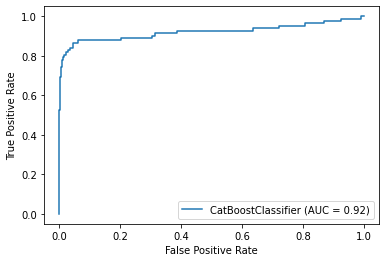

In [35]:
from sklearn.metrics import plot_roc_curve, roc_auc_score

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)


plot_roc_curve(model, X_test, y_test)

In [39]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.98       518
        True       0.94      0.77      0.85        82

    accuracy                           0.96       600
   macro avg       0.95      0.88      0.91       600
weighted avg       0.96      0.96      0.96       600



# Exporting the Model

In [40]:
model.fit(X, y, cat_features=categorical_features)

Learning rate set to 0.016467
0:	learn: 0.6781052	total: 10.2ms	remaining: 10.2s
100:	learn: 0.2028217	total: 444ms	remaining: 3.95s
200:	learn: 0.1483237	total: 768ms	remaining: 3.05s
300:	learn: 0.1289760	total: 1.06s	remaining: 2.47s
400:	learn: 0.1173462	total: 1.4s	remaining: 2.08s
500:	learn: 0.1082947	total: 1.69s	remaining: 1.69s
600:	learn: 0.1019717	total: 1.97s	remaining: 1.31s
700:	learn: 0.0965252	total: 2.28s	remaining: 971ms
800:	learn: 0.0896938	total: 2.56s	remaining: 636ms
900:	learn: 0.0828129	total: 2.86s	remaining: 314ms
999:	learn: 0.0764873	total: 3.15s	remaining: 0us


In [41]:
model.save_model('catboost_model.cbm', format='cbm')